In [ ]:
!python3 -m pip install --upgrade --quiet google-genai

In [1]:
!gcloud storage cp gs://qwiklabs-gcp-01-3c27ad30b4bd-bucket/empty-bowl-on-empty-table.png .
!gcloud storage cp gs://qwiklabs-gcp-01-3c27ad30b4bd-bucket/image_editing_utils.py .
!gcloud storage cp gs://qwiklabs-gcp-01-3c27ad30b4bd-bucket/place-setting-mask.png .

Copying gs://qwiklabs-gcp-01-3c27ad30b4bd-bucket/empty-bowl-on-empty-table.png to file://./empty-bowl-on-empty-table.png
  Completed files 1/1 | 1.4MiB/1.4MiB                                          

Average throughput: 96.8MiB/s
Copying gs://qwiklabs-gcp-01-3c27ad30b4bd-bucket/image_editing_utils.py to file://./image_editing_utils.py
  Completed files 1/1 | 5.0kiB/5.0kiB                                          
Copying gs://qwiklabs-gcp-01-3c27ad30b4bd-bucket/place-setting-mask.png to file://./place-setting-mask.png
  Completed files 1/1 | 4.5kiB/4.5kiB                                          


In [2]:
from google import genai
from google.genai.types import (
    Image,
    EditImageConfig,
    RawReferenceImage,
    MaskReferenceImage,
    MaskReferenceConfig,
)

import image_editing_utils

In [3]:
PROJECT_ID = "qwiklabs-gcp-01-3c27ad30b4bd"
LOCATION = "us-central1"
gcs_bucket = "qwiklabs-gcp-01-3c27ad30b4bd-bucket"

client = genai.Client(
    vertexai=True,
    project=PROJECT_ID,
    location=LOCATION
)

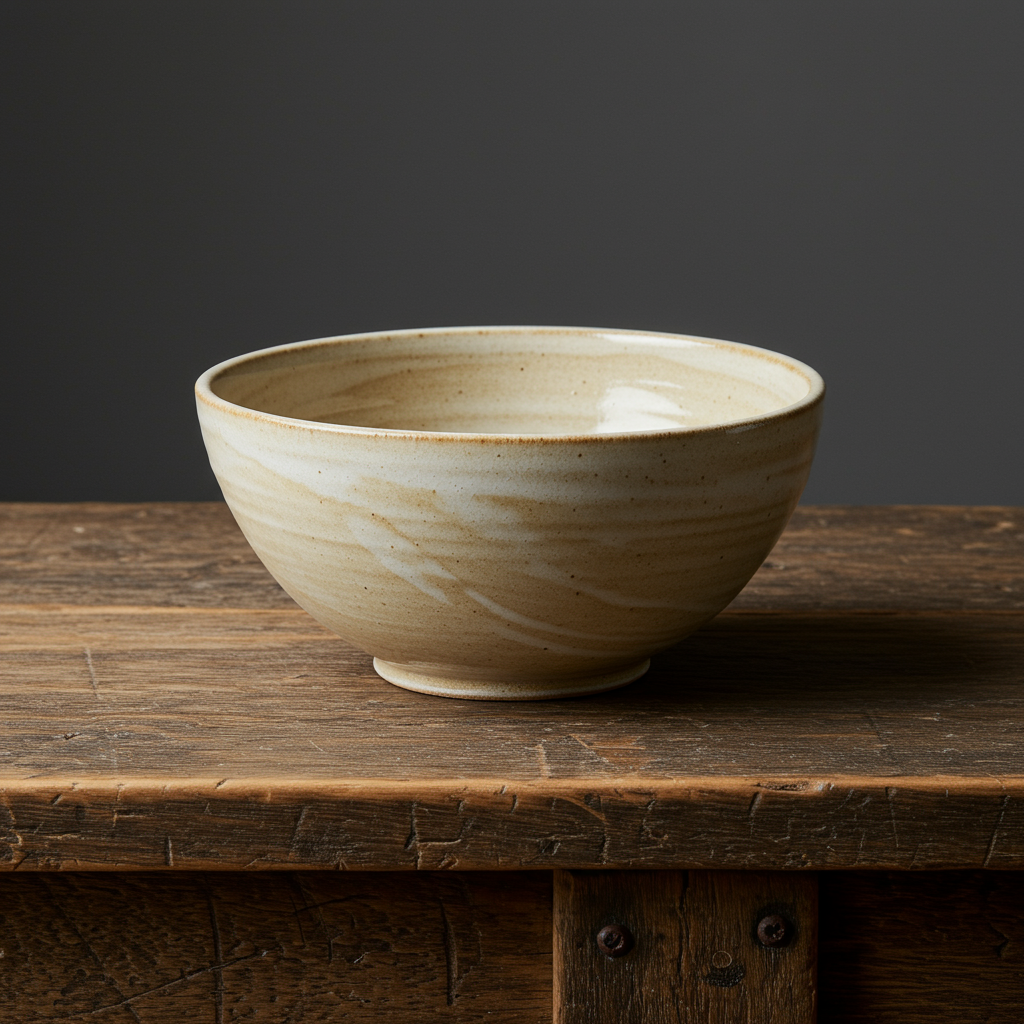

In [4]:
original_image = Image.from_file(
    location="empty-bowl-on-empty-table.png",
    mime_type="image/png"
)
original_image.show()

In [5]:
dest_filename = "empty-bowl-on-empty-table-copy.png"
original_image.save(dest_filename)
image_editing_utils.upload_file_to_gcs(
    gcs_bucket, dest_filename, dest_filename)

File empty-bowl-on-empty-table-copy.png uploaded to empty-bowl-on-empty-table-copy.png.


In [6]:
edit_model_name = "imagen-3.0-capability-001"

In [13]:
target_image_size = (1408, 768)

reframed_image, reframed_mask = image_editing_utils.pad_and_mask_image(
    original_image=original_image,
    target_size=target_image_size,
    vertical_offset_from_bottom=0.5,
    horizontal_offset_from_left=0.1,
)

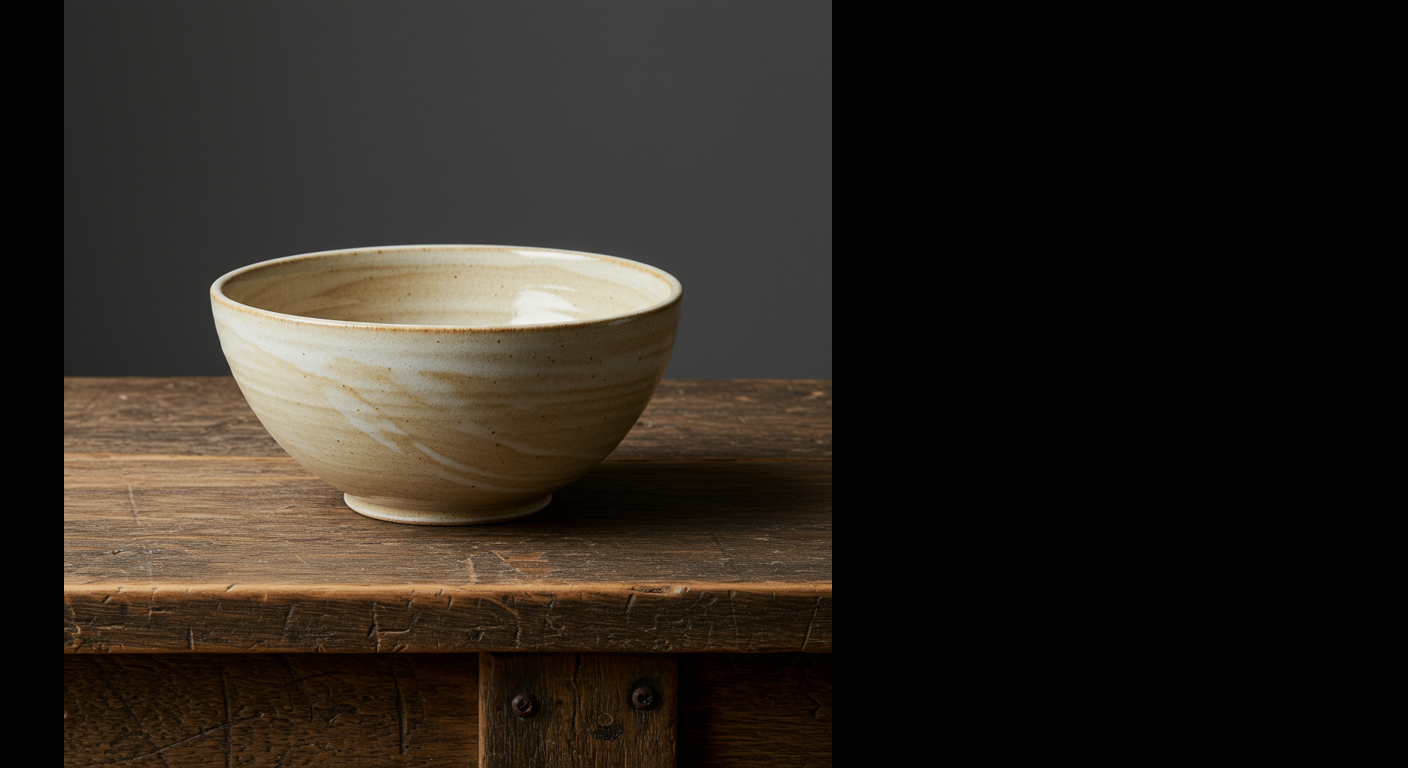

In [14]:
reframed_image.show()

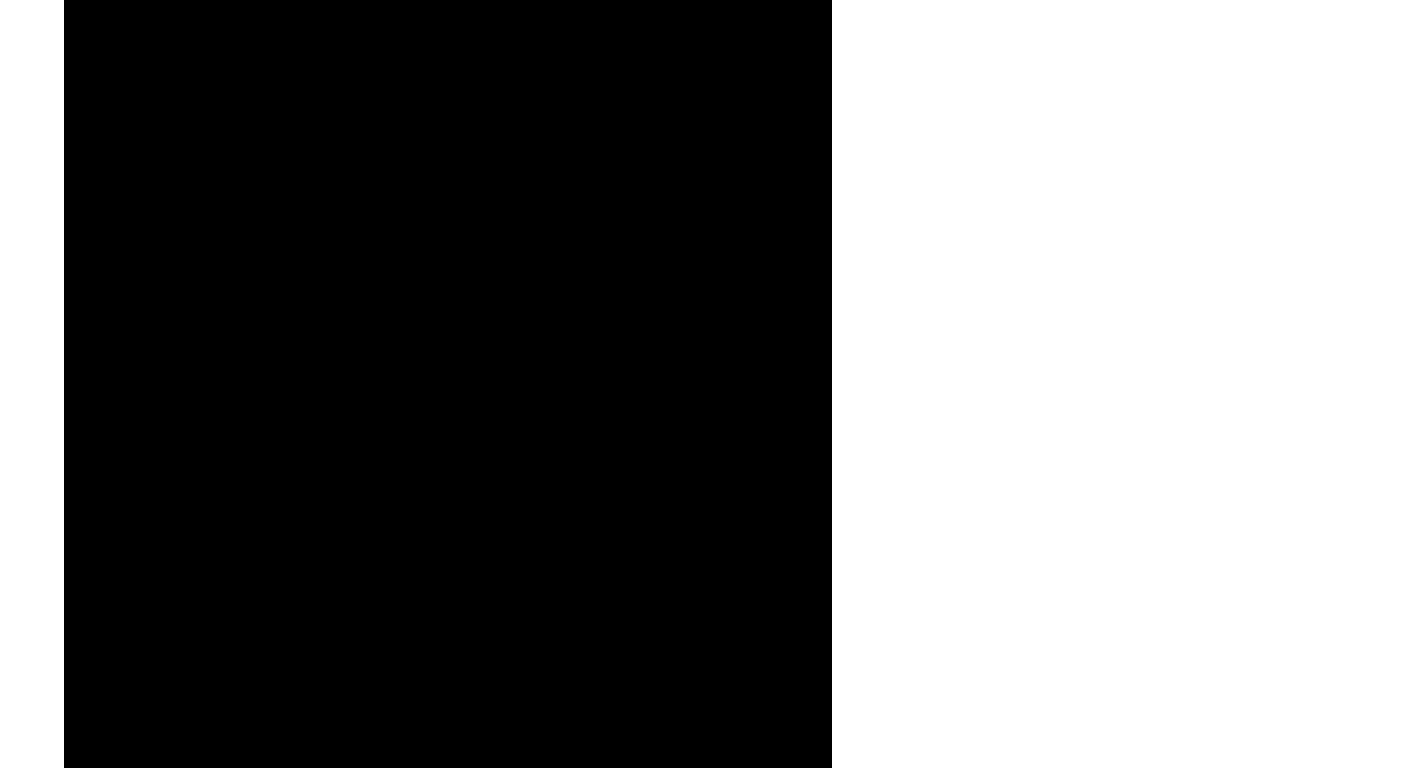

In [15]:
reframed_mask.show()

In [16]:
raw_ref_image = RawReferenceImage(
    reference_image=reframed_image,
    reference_id=0
)

mask_ref_image = MaskReferenceImage(
    reference_id=1,
    reference_image=reframed_mask,
    config=MaskReferenceConfig(
        mask_mode="MASK_MODE_USER_PROVIDED",
        mask_dilation=0.1,
    )
)

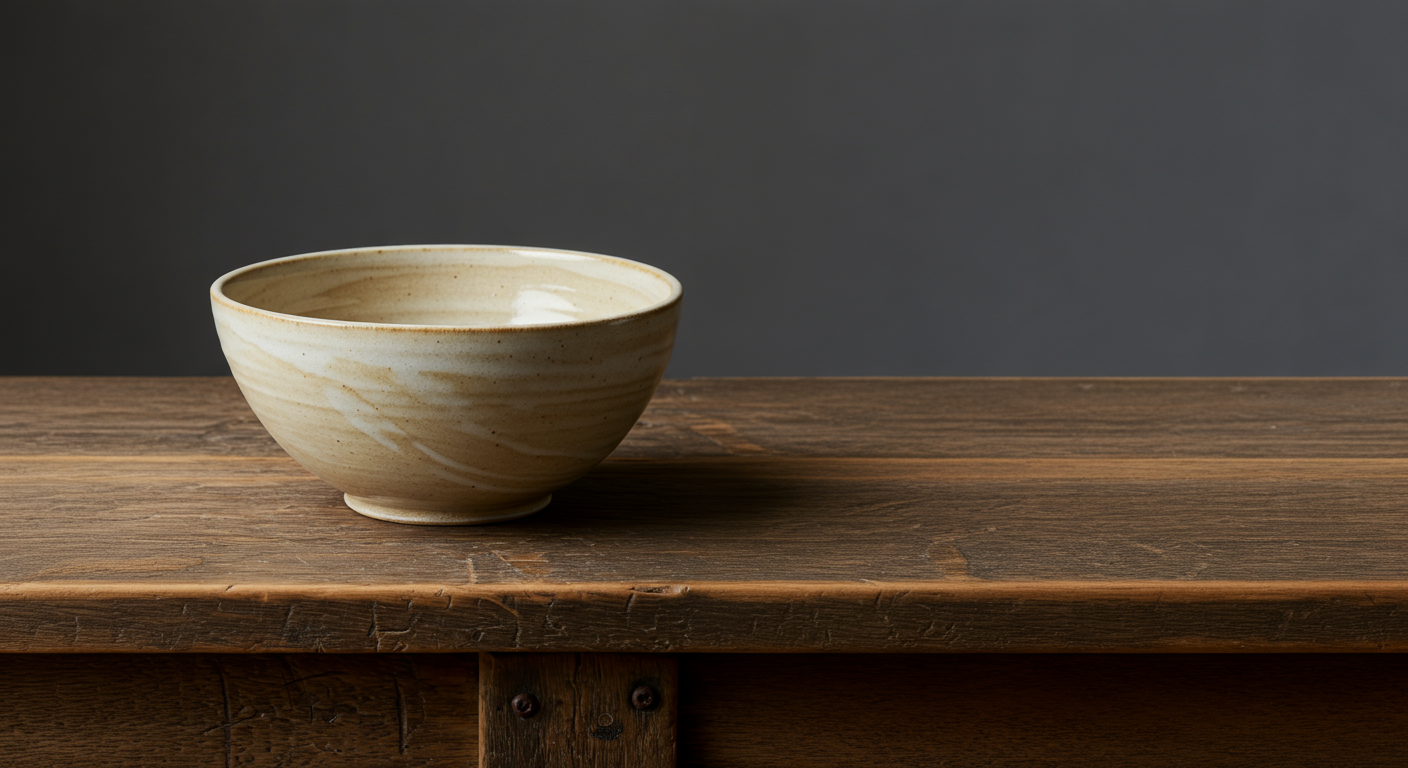

In [17]:
outpainted_image = client.models.edit_image(
    model=edit_model_name,
    prompt="",
    reference_images=[raw_ref_image, mask_ref_image],
    config=EditImageConfig(
        edit_mode= "EDIT_MODE_OUTPAINT", #ENTER_THE_CORRECT_EDIT_MODE
        number_of_images=1,
        base_steps=35,
        safety_filter_level="BLOCK_ONLY_HIGH",
    ),
)

outpainted_image.generated_images[0].image.show()

In [18]:
filename = "empty-bowl-on-long-table.png"

outpainted_image.generated_images[0].image.save(filename)
image_editing_utils.upload_file_to_gcs(
    gcs_bucket, filename, filename)

File empty-bowl-on-long-table.png uploaded to empty-bowl-on-long-table.png.


In [24]:
raw_ref_image = RawReferenceImage(
    reference_image=reframed_image, # Reference your outpainted image here
    reference_id=0
)

In [25]:
edit_prompt = "photoreal wet grapes added to the ceramic bowl[0]."
edited_image = client.models.edit_image(
    model=edit_model_name,
    prompt=edit_prompt,
    reference_images=[raw_ref_image],
    config=EditImageConfig(
        edit_mode="EDIT_MODE_OUTPAINT", #ENTER_THE_CORRECT_EDIT_MODE
        base_steps=35,
        number_of_images=1,
        safety_filter_level="BLOCK_MEDIUM_AND_ABOVE",
    ),
)

edited_image.generated_images[0].image.show()

ClientError: 400 INVALID_ARGUMENT. {'error': {'code': 400, 'message': 'Image editing failed with the following error: Mask image is missing.', 'status': 'INVALID_ARGUMENT'}}

In [26]:
filename = "grapes-in-bowl-on-long-table.png"

edited_image.generated_images[0].image.save(filename)
image_editing_utils.upload_file_to_gcs(
    gcs_bucket, filename, filename)

NameError: name 'edited_image' is not defined

In [ ]:
raw_ref_image = RawReferenceImage(
    reference_image=outpainted_image.generated_images[0].image, # Reference your edited image here,
    reference_id=0
)

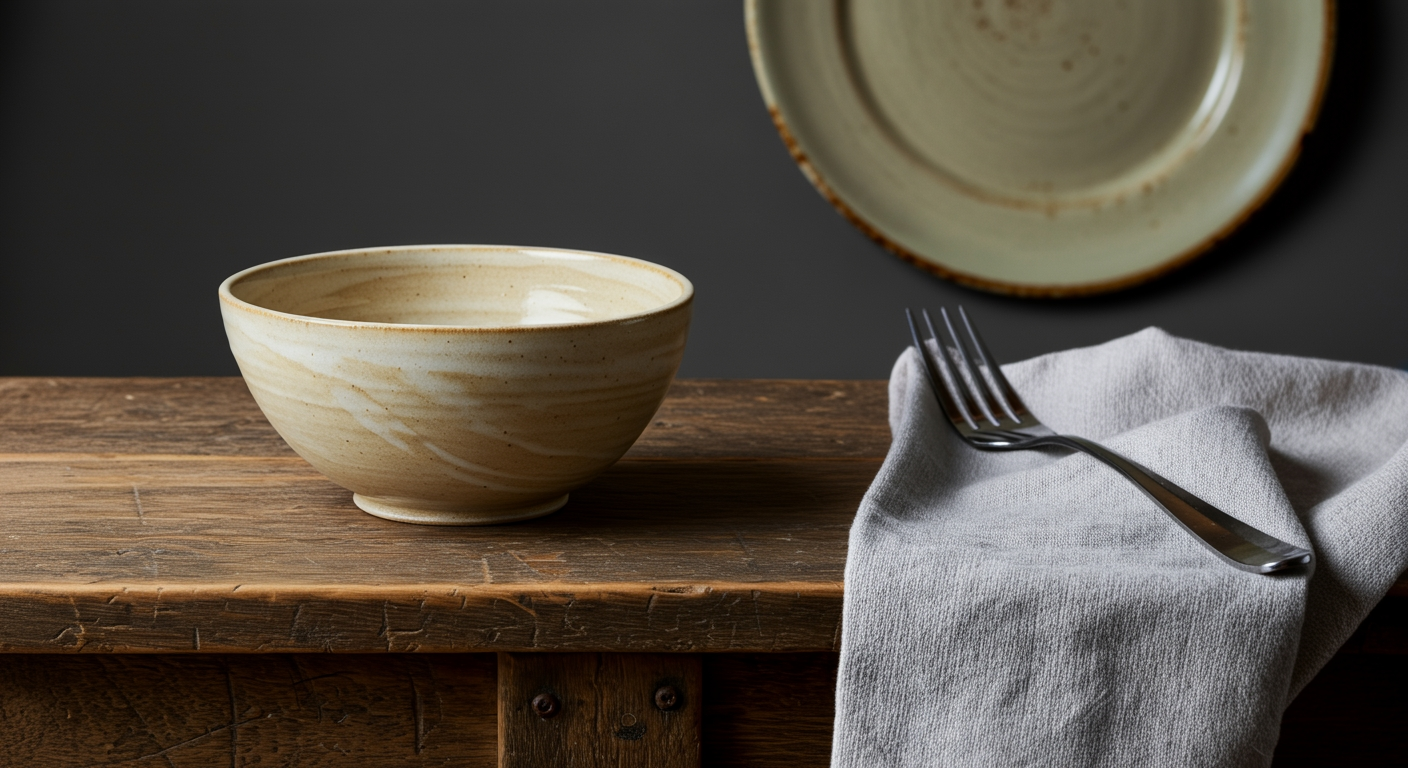

In [29]:
edit_prompt = "a fork on a napkin and a plate on the rustic table[1]"
inpainted_image = client.models.edit_image(
    model=edit_model_name,
    prompt=edit_prompt,
    reference_images=[raw_ref_image, mask_ref_image],
    config=EditImageConfig(
        edit_mode="EDIT_MODE_DEFAULT", #ENTER_THE_CORRECT_EDIT_MODE ,
        number_of_images=1,
        safety_filter_level="BLOCK_MEDIUM_AND_ABOVE",
    ),
)

inpainted_image.generated_images[0].image.show()

In [30]:
filename = "grapes-and-table-setting-on-long-table.png"

inpainted_image.generated_images[0].image.save(filename)
image_editing_utils.upload_file_to_gcs(
    gcs_bucket, filename, filename)

File grapes-and-table-setting-on-long-table.png uploaded to grapes-and-table-setting-on-long-table.png.


In [31]:
raw_ref_image = RawReferenceImage(
    reference_image=edited_image.generated_images[0].image, # Reference your inpainted image here,
    reference_id=0
)

In [32]:
place_setting_mask = Image.from_file(location="place-setting-mask.png")
mask_ref_image = MaskReferenceImage(
    reference_id=1,
    reference_image=place_setting_mask,
    config=MaskReferenceConfig(
        mask_mode="MASK_MODE_USER_PROVIDED",
        mask_dilation=0.1,
    )
)